In [57]:
import os

from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_v2_s
from torchvision.transforms import v2

from src.save_model import save_model
from src.train_model import train_one_epoch

In [2]:
torch.cuda.empty_cache()

### 1. Загрузка и предобразботка данных

In [3]:
train_transforms = v2.Compose([
    v2.RandomRotation([-10, 10], fill=255),
    # v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomPhotometricDistort(contrast=[0.9, 1.1],
                                hue=[-0.05, 0.05]),
                                v2.Resize((384, 384)),
                                v2.ToTensor(),
                                v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])
val_transforms = v2.Compose([
    v2.Resize((384, 384)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

/home/user/tablet_classifier/.venv/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
train_dataset = ImageFolder('ogyeiv2/train', transform=train_transforms)
val_dataset = ImageFolder('ogyeiv2/test', transform=val_transforms)

In [5]:
classes = train_dataset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.160364..2.64].


algoflex_forte_dolo_400_mg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30553368..2.622571].


algoflex_forte_dolo_400_mg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42255333..2.64].


algoflex_forte_dolo_400_mg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.792717..2.64].


algoflex_forte_dolo_400_mg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91526604..2.343704].


algoflex_forte_dolo_400_mg


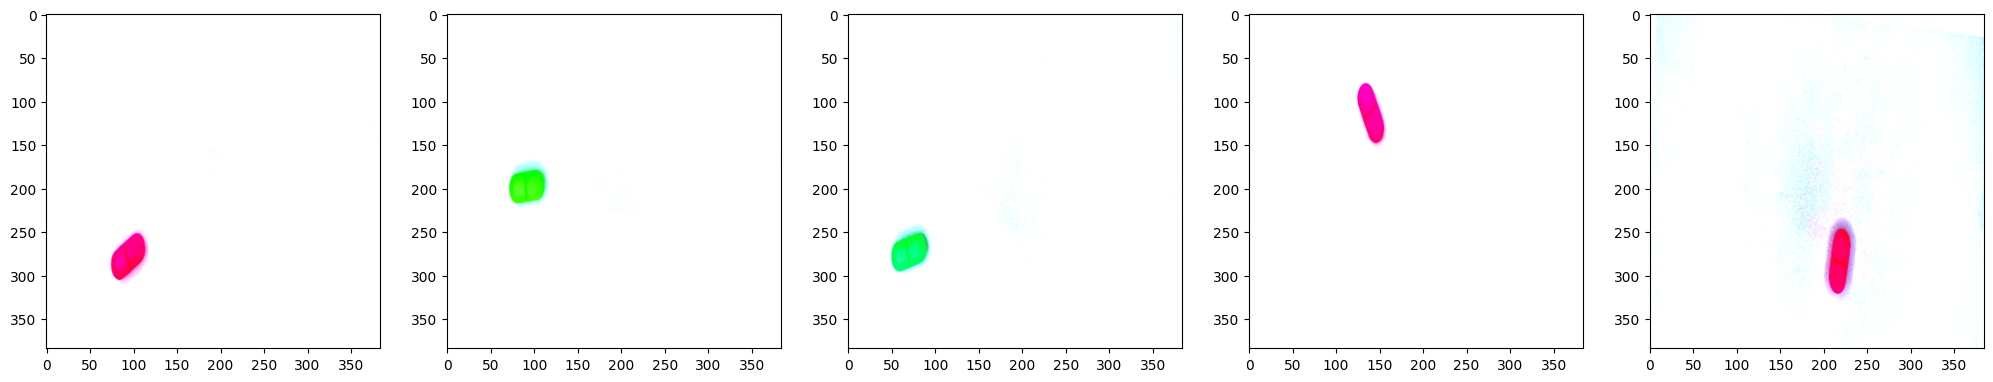

In [6]:
fig = plt.figure(figsize=(25, 5))
for i in range(1, 6):
    image, label = train_dataset[100 + i]
    plt.subplot(1, 5, i)
    plt.imshow(image.permute((1, 2, 0)))
    print(classes[label])
plt.show()


In [7]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=20, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, num_workers=20, pin_memory=True)

In [8]:
print('Количество классов:', len(classes))
print('Количество изображений в обучающем датасете:', len(train_dataset))
print('Количество изображений в валидационном датасете:', len(val_dataset))

Количество классов: 84
Количество изображений в обучающем датасете: 2352
Количество изображений в валидационном датасете: 504


### 2. Объявление модели

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Устройство обучения:', device)

Устройство обучения: cuda


##### Дообучение модели

In [10]:
model = efficientnet_v2_s(weights='IMAGENET1K_V1')

In [11]:
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features=in_features, out_features=84)

In [12]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.classifier.parameters():
    param.requires_grad = True

In [15]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

### 3. Обучение или дообучение

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
EPOCHS = 50

In [18]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = train_one_epoch(train_loader=train_loader, model=model,
                                 criterion=criterion, optimizer=optimizer,
                                 device=device, epoch_index=epoch)
    print(f'Epoch: {epoch}, train loss: {train_loss}')
    train_losses.append(train_loss)
    
    running_vloss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_vloss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss = running_vloss / len(val_loader)
    val_accuracy = correct / total
    print(f'Epoch: {epoch}, val loss: {val_loss}, val accuracy: {val_accuracy}')
    val_losses.append(val_loss)

    save_model(model.state_dict(), f'meds_classifier_{epoch}.pt')

    print('-' * 50)

Эпоха: 0, номер батча: 19, ошибка: 4.415178608894348
Epoch: 0, train loss: 4.415178608894348
Epoch: 0, val loss: 3.9886297285556793, val accuracy: 0.25
--------------------------------------------------
Эпоха: 1, номер батча: 19, ошибка: 4.025980138778687
Epoch: 1, train loss: 4.025980138778687
Epoch: 1, val loss: 3.61056849360466, val accuracy: 0.42063492063492064
--------------------------------------------------
Эпоха: 2, номер батча: 19, ошибка: 3.725038981437683
Epoch: 2, train loss: 3.725038981437683
Epoch: 2, val loss: 3.3043152391910553, val accuracy: 0.4781746031746032
--------------------------------------------------
Эпоха: 3, номер батча: 19, ошибка: 3.4631845712661744
Epoch: 3, train loss: 3.4631845712661744
Epoch: 3, val loss: 3.0206153094768524, val accuracy: 0.49603174603174605
--------------------------------------------------
Эпоха: 4, номер батча: 19, ошибка: 3.2601274728775023
Epoch: 4, train loss: 3.2601274728775023
Epoch: 4, val loss: 2.8130041658878326, val accur

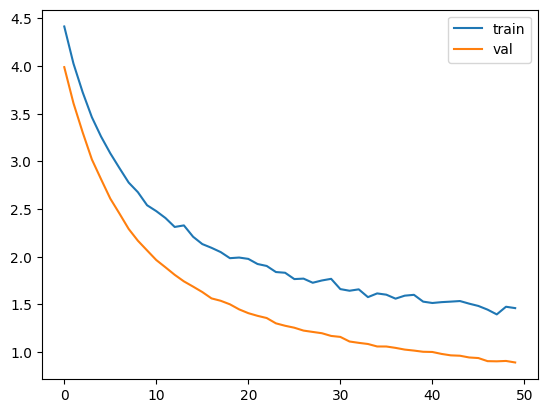

In [19]:
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

### 4. Оценка качества

In [24]:
labels_predicted = []
labels_true = []

model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1) # argmax по всем примерам
        labels_predicted.extend(predicted.cpu().numpy())
        labels_true.extend(labels.cpu().numpy())

print(classification_report(labels_true, labels_predicted, target_names=classes))

                                  precision    recall  f1-score   support

                 acc_long_600_mg       0.86      1.00      0.92         6
               advil_ultra_forte       1.00      0.83      0.91         6
                   akineton_2_mg       0.75      1.00      0.86         6
      algoflex_forte_dolo_400_mg       1.00      0.83      0.91         6
           algoflex_rapid_400_mg       0.75      1.00      0.86         6
                algopyrin_500_mg       0.80      0.67      0.73         6
             ambroxol_egis_30_mg       0.80      0.67      0.73         6
                  apranax_550_mg       1.00      1.00      1.00         6
            aspirin_ultra_500_mg       0.56      0.83      0.67         6
                    atoris_20_mg       0.75      0.50      0.60         6
         atorvastatin_teva_20_mg       0.67      0.67      0.67         6
                   betaloc_50_mg       0.56      0.83      0.67         6
                        bila_git     

/home/user/tablet_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/user/tablet_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/user/tablet_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

In [ ]:
# сохранение результата в виде dict
od = classification_report(labels_true, labels_predicted, target_names=classes, output_dict=True)

/home/user/tablet_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/user/tablet_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/user/tablet_classifier/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

In [ ]:
# получение метрики f1-score для каждого класса
f1 = []
f1_k = []
for k, v in od.items():
    if isinstance(v, dict):
        f1.append(v['f1-score'])
        f1_k.append(k)

In [ ]:
# сортировка в порядке возрастания значения f1-score
paired_lists = zip(f1_k, f1)
sorted_pairs = sorted(paired_lists, key=lambda x: x[1])

Название класса: naturland_d_vitamin_forte значение f1-score: 0.0


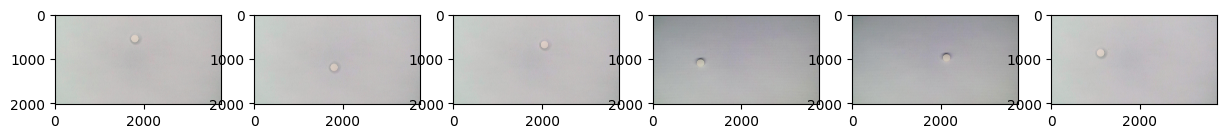

--------------------------------------------------
Название класса: vitamin_d3_fresenius_1000_ne значение f1-score: 0.4


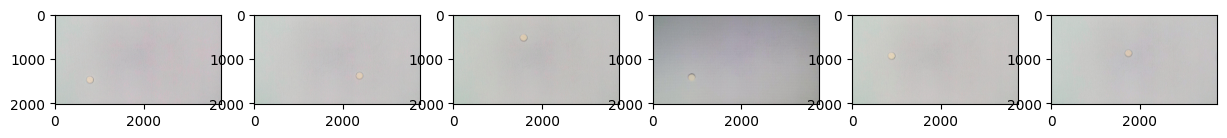

--------------------------------------------------
Название класса: kalium_r значение f1-score: 0.42857142857142855


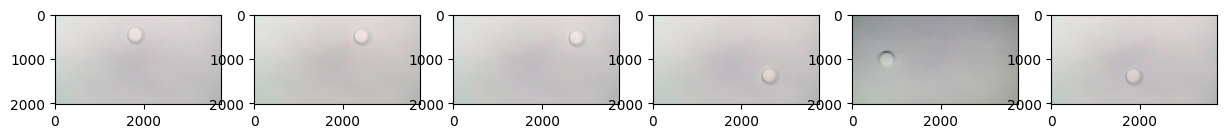

--------------------------------------------------
Название класса: kalcium_magnezium_cink значение f1-score: 0.4444444444444444


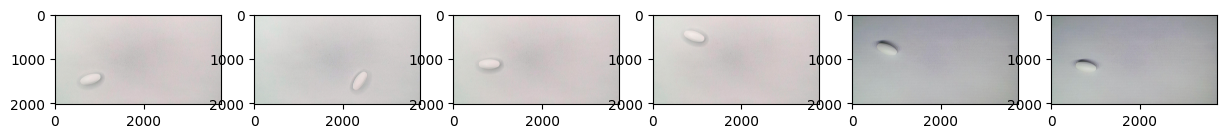

--------------------------------------------------
Название класса: normodipine_5_mg значение f1-score: 0.4444444444444444


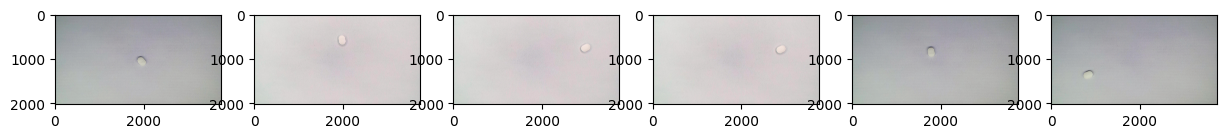

--------------------------------------------------


In [ ]:
# вывод 5 классов, с найименьшим f1-score
for k, f1 in sorted_pairs[:5]:
    print('Название класса:', k, 'значение f1-score:', f1)
    class_folder = os.path.join('ogyeiv2/test', k)
    files = os.listdir(class_folder)
    plt.figure(figsize=(15, 5))
    for file_index, f in enumerate(files):
        plt.subplot(1, len(files), file_index + 1)
        img = Image.open(os.path.join(class_folder, f))
        plt.imshow(img)
    plt.show()
    print('-' * 50)

На каких 5 классах модель ошибается чаще всего?
- на таблетках, которые не имеют особых отличительных черт (как показано выше на белых таблетках);

Почему модель может ошибаться на этих классах?
- модель ошибается, потому что не может явно определить класс (к примеру, путается между белыми овальными таблетками, которые визуально, по предоставленным изображениям, нельзя отнести к определенному класса);

На каких классах модель не совершает ошибок?
- модель не совершает ошибок на таблетках, которые имеют специфические цвет, форму и т.д. (признаки, которые отличают их от других таблеток);

Почему эти классы модель распознаёт безошибочно?
- потому что эти классы легко различимы и можно без труда соотнести таблетку с классом;

Как можно улучшить точность классификатора?
- оставить только те, классы, которые имеют явные, присущие только им внешние признаки;
- увеличить разрешение каждой картинки;

Как ещё можно проанализировать результаты и ошибки модели?
- использовать более объемную валидационную выборку;